# Testing and Evaluation of Pneumonia Detection Model

## Overview
This notebook evaluates the trained InceptionV3 model for pneumonia detection and classification.

### Results Summary
- Three-way Classification Accuracy: 79.01%
- Binary Classification Accuracy: 89.74%
- Sensitivity: 99.23%
- Specificity: 73.93%

### Evaluation Metrics
1. Three-way Classification (Normal/Bacterial/Viral)
2. Binary Classification (Normal/Pneumonia)
3. Sensitivity and Specificity Analysis
4. Confusion Matrix Visualization

### Clinical Implications
- High sensitivity, specifically for detecting bacterial pneumonia, makes the model suitable for screening
- Good differentiation between normal and pneumonia cases
- Some confusion between bacterial and viral pneumonia types

## 1. Setup

Mount Google Drive and prepare environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/datasets/test /content/test
!cp -r /content/drive/MyDrive/datasets/train /content/train

## 2. Model Loading

Load the trained model with proper architecture configuration.

In [3]:
import torch
import torch.nn as nn
from torchvision import models

#Load Model in exact same setup as training
model = models.inception_v3(pretrained=True)  # Use pretrained weights
model.aux_logits = True

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Modify and unfreeze just the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Unfreeze only Mixed_7b, Mixed_7c, and fc layers
for name, param in model.named_parameters():
    if 'Mixed_7b' in name or 'Mixed_7c' in name or 'fc' in name:
        param.requires_grad = True

model.eval()  # Important!
torch.set_grad_enabled(False)  # Also disable gradients during inference



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 146MB/s]


## 3. Data Preparation

Prepare test dataset with appropriate normalization and transforms.

In [4]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the training dataset with a simple transform to compute mean and std
train_transform_simple = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

train_dataset_simple = datasets.ImageFolder(root='/content/train', transform=train_transform_simple)
train_loader_simple = DataLoader(train_dataset_simple, batch_size=32, shuffle=False, num_workers=2)

def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = compute_mean_std(train_loader_simple)
print(f'Computed Mean: {mean}, Std: {std}')

Computed Mean: tensor([0.4823, 0.4823, 0.4823]), Std: tensor([0.2220, 0.2220, 0.2220])


In [ ]:
# Load the weights
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/Inception_1layer_nodropout_weights_3.pth'))

# After loading weights:
model.train(False)  # This ensures batch norm uses running statistics


In [ ]:
# Print model parameter count before and after loading
print("Model architecture:")
print(model)
print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))

# Check a few sample weights to ensure they're not all zeros or random
for name, param in model.fc.named_parameters():
    print(f"\nFinal layer {name} stats:")
    print("Mean:", param.data.mean().item())
    print("Std:", param.data.std().item())

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

In [8]:
# Apply the computed mean and std to both the train and test datasets for evaluation
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Use computed mean and std
])

test_dataset = datasets.ImageFolder(root='/content/test', transform=test_transform)
train_dataset = datasets.ImageFolder(root='/content/train', transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes)
print(test_dataset.class_to_idx)

['a_normal_xrays', 'bacterial pneumonia', 'viral pneumonia']
{'a_normal_xrays': 0, 'bacterial pneumonia': 1, 'viral pneumonia': 2}


## 4. Model Evaluation Method

Comprehensive evaluation including:
- Confusion matrix generation
- Multi-class metrics calculation
- Binary classification metrics
- Performance visualization

In [10]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def comprehensive_evaluation(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # 1. Three-way classification metrics
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy_3way = accuracy_score(all_labels, all_predictions)

    # 2. Normal vs Any Pneumonia
    # Convert predictions to binary (0 for normal, 1 for any pneumonia)
    binary_labels = (all_labels > 0).astype(int)
    binary_preds = (all_predictions > 0).astype(int)

    accuracy_binary = accuracy_score(binary_labels, binary_preds)
    sensitivity_binary = recall_score(binary_labels, binary_preds)  # Sensitivity is same as recall

    # Calculate specificity manually (True Negatives / (True Negatives + False Positives))
    tn, fp, fn, tp = confusion_matrix(binary_labels, binary_preds).ravel()
    specificity_binary = tn / (tn + fp)

    # 3. Bacterial vs Viral (only for pneumonia cases)
    pneumonia_mask = (all_labels > 0)  # Only look at pneumonia cases
    if np.any(pneumonia_mask):  # Check if there are any pneumonia cases
        bacterial_viral_labels = all_labels[pneumonia_mask] - 1  # Subtract 1 to convert to 0/1
        bacterial_viral_preds = all_predictions[pneumonia_mask] - 1
        accuracy_bac_vir = accuracy_score(bacterial_viral_labels, bacterial_viral_preds)
    else:
        accuracy_bac_vir = None

    # Print results
    print("\n=== Three-way Classification ===")
    print(f"Overall Accuracy: {accuracy_3way*100:.2f}%")

    print("\n=== Normal vs Any Pneumonia ===")
    print(f"Accuracy: {accuracy_binary*100:.2f}%")
    print(f"Sensitivity: {sensitivity_binary*100:.2f}%")
    print(f"Specificity: {specificity_binary*100:.2f}%")

    print("\n=== Bacterial vs Viral Pneumonia ===")
    if accuracy_bac_vir is not None:
        print(f"Accuracy: {accuracy_bac_vir*100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Bacterial', 'Viral'],
                yticklabels=['Normal', 'Bacterial', 'Viral'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy_3way, accuracy_binary, accuracy_bac_vir, conf_matrix

## 5. Evaluate Model

Comprehensive evaluation including:
- Confusion matrix generation
- Multi-class metrics calculation
- Binary classification metrics
- Performance visualization


=== Three-way Classification ===
Overall Accuracy: 79.01%

=== Normal vs Any Pneumonia ===
Accuracy: 89.74%
Sensitivity: 99.23%
Specificity: 73.93%

=== Bacterial vs Viral Pneumonia ===
Accuracy: 82.05%


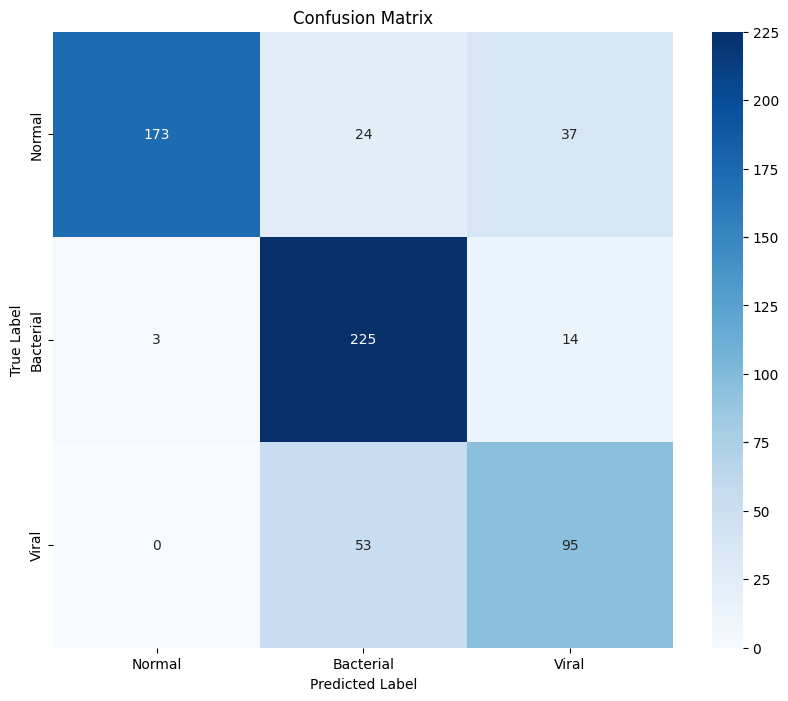

In [11]:

# Call the evaluation function
accuracy_3way, accuracy_binary, accuracy_bac_vir, conf_matrix = comprehensive_evaluation(model, test_loader, device)